In [ ]:
!unzip ../data/01/archive.zip -d ../data/03/fer_13

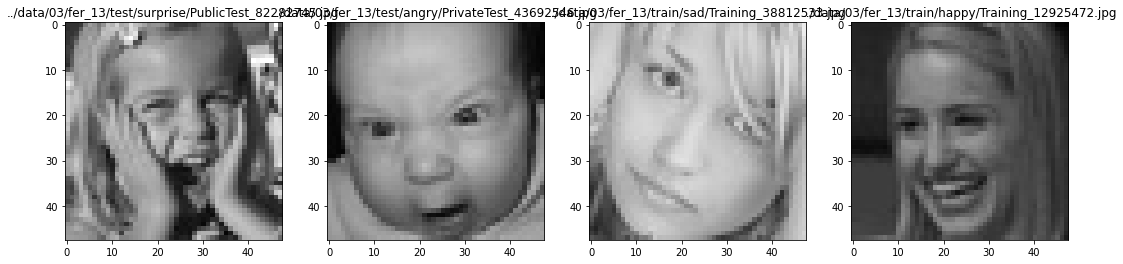

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
import cv2

fer_files =  glob('../data/03/fer_13/*/*/**.jpg')

plt.figure(figsize=(18, 4))

for i in range(4):
    file = fer_files[randint(0, len(fer_files) -1 )]
    image = mpimg.imread(file)
    ax = plt.subplot(1, 4, i + 1)
    plt.title(file)
    plt.imshow(cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE))
    
plt.show()

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling

train_ds = image_dataset_from_directory(
		os.path.join(data_folder, 'train'),
		image_size=(base_dim, base_dim),
		batch_size=64,
		color_mode='grayscale',
		label_mode='categorical'
)

normalization_layer = Rescaling(1./255)
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

data_folder = '../data/03/fer_13/'

train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    os.path.join(data_folder, 'train'),
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

validation_generator = test_data_gen.flow_from_directory(
    os.path.join(data_folder, 'test'),
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

2022-08-01 23:16:05.523219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gio/Dev/listen_yourself/env/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-01 23:16:05.523242: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Tensorflow dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout
import tensorflow as tf

In [21]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

In [22]:
import tensorboard
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow_addons import F1Score

tensorboard_cb = TensorBoard(
    '../models/logs', 
    histogram_freq=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

callbacks = [
    tensorboard_cb,
    reduce_lr_cb,
    early_stopping_cb
]

In [23]:
model_info = model.fit(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

model_json = model.to_json()
if not os.path.exists('../models/fer_2013'):
    os.makedirs('../models/fer_2013/')
with open('../models/fer_2013/model.json', 'w') as f:
    f.write(model_json)

Epoch 1/50
448/448 [==============================] - 125s 277ms/step - loss: 1.8032 - accuracy: 0.2606 - val_loss: 1.7205 - val_accuracy: 0.3430 - lr: 1.0000e-04
Epoch 2/50
448/448 [==============================] - 124s 277ms/step - loss: 1.6249 - accuracy: 0.3677 - val_loss: 1.5445 - val_accuracy: 0.4188 - lr: 1.0000e-04
Epoch 3/50
448/448 [==============================] - 124s 277ms/step - loss: 1.5254 - accuracy: 0.4131 - val_loss: 1.4664 - val_accuracy: 0.4466 - lr: 1.0000e-04
Epoch 4/50
448/448 [==============================] - 124s 277ms/step - loss: 1.4478 - accuracy: 0.4470 - val_loss: 1.3815 - val_accuracy: 0.4748 - lr: 1.0000e-04
Epoch 5/50
448/448 [==============================] - 124s 276ms/step - loss: 1.3804 - accuracy: 0.4747 - val_loss: 1.3396 - val_accuracy: 0.4894 - lr: 1.0000e-04
Epoch 6/50
448/448 [==============================] - 123s 274ms/step - loss: 1.3270 - accuracy: 0.4989 - val_loss: 1.2871 - val_accuracy: 0.5152 - lr: 1.0000e-04
Epoch 7/50
448/448 [==

In [26]:
model.save_weights('../models/fer_2013/model.h5')

In [1]:
emotions_dict = {
    0: 'Angry',
    1: 'Disgusted',
    2: 'Fearful',
    3: 'Happy',
    4: 'Neutral',
    5: 'Sad',
    6: 'Surprised'
}

In [6]:
emotions_rawdess = os.listdir('../data/03/original_size/train')
emotions_rawdess

['neutral', 'sad', 'surprised', 'fearful', 'calm', 'angry', 'disgust', 'happy']

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-07 00:51:09.324091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 00:51:09.358742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 00:51:09.359350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
from tensorflow.keras.models import model_from_json

# with open('../models/fer_2013/model.json', 'r') as f:
#     loaded_json = f.read()

# model = model_from_json(loaded_json)
# model.load_weights('../models/fer_2013/model.h5')
with open('../models/ravdess_1.0/model_48x48.json', 'r') as f:
    loaded_json = f.read()
model = model_from_json(loaded_json)
model.load_weights('../models/ravdess_1.0/model_48x48.h5')

2022-08-07 00:51:09.458037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 00:51:09.458886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 00:51:09.459670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 00:51:09.460135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
import os
from tabnanny import verbose
import cv2
# import skvideo.io
from glob import glob
import numpy as np
from random import randint

videos = glob('../data/test_face_recognition/*.mp4')
rdm_video = videos[randint(0, len(videos) - 1)]
# cap = cv2.VideoCapture(rdm_video)
cap = cv2.VideoCapture(0)
while True:
    success, frame = cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (640, 480))
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img, verbose=0)
        # print(dict(zip(emotions_dict.keys(), prediction[0])))
        max_index = int(np.argmax(prediction))
        # cv2.putText(frame, emotions_dict[max_index], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, emotions_rawdess[max_index], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow(f'Emotion Detection : {os.path.basename(rdm_video)}', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
# cv2.destroyAllWindows()

[ WARN:0@0.009] global /opt/conda/conda-bld/opencv-suite_1655999675620/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
2022-08-07 00:51:11.672538: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-07 00:51:12.087355: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


KeyError: 7

In [8]:
cv2.destroyAllWindows()